In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import argparse
import os
import random
import re

import matplotlib.animation as mplanim
import matplotlib.pyplot as plt
import numpy as np
import s3fs
import torch
import umap

import celltrip


os.environ['AWS_PROFILE'] = 'waisman-admin'

In [3]:
# Arguments # TODO REPLACE
parser = argparse.ArgumentParser(description='Train CellTRIP model', formatter_class=argparse.ArgumentDefaultsHelpFormatter)

# Reading
group = parser.add_argument_group('Input')
group.add_argument('input_files', type=str, nargs='*', help='h5ad files to be used for input')
group.add_argument('--merge_files', type=str, action='append', nargs='+', help='h5ad files to merge as input')
group.add_argument('--partition_cols', type=str, action='append', nargs='+', help='Columns for data partitioning, found in `adata.obs` DataFrame')
group.add_argument('--backed', action='store_true', help='Read data directly from disk or s3, saving memory at the cost of time')
group.add_argument('--input_modalities', type=int, nargs='+', help='Input modalities to give to CellTRIP')
group.add_argument('--target_modalities', type=int, nargs='+', help='Target modalities to emulate, dictates environment reward')
# Computation
group = parser.add_argument_group('Computation')
group.add_argument('--num_gpus', type=int, default=1, help='Number of GPUs to use during computation')
group.add_argument('--num_learners', type=int, default=1, help='Number of learners used in backward computation, cannot exceed GPUs')
group.add_argument('--num_runners', type=int, default=1, help='Number of workers for environment simulation')
# Training
group = parser.add_argument_group('Training')
group.add_argument('--steps', type=int, default=int(5e3), help='Number of steps recorded before each update')
group.add_argument('--max_updates', type=int, default=200, help='Maximum number of policy updates to compute before exiting')
group.add_argument('--dont_sync_across_nodes', action='store_true', help='Avoid memory sync across nodes, saving overhead time at the cost of stability')
# File saves
group = parser.add_argument_group('Logging')
group.add_argument('--logfile', type=str, default='cli', help='Location for log file, can be `cli`, `<local_file>`, or `<s3 location>`')
group.add_argument('--flush_iterations', type=int, help='Number of iterations to wait before flushing logs')
group.add_argument('--checkpoint', type=str, help='Checkpoint to use for initializing model')
group.add_argument('--checkpoint_iterations', type=int, default=20, help='Number of iterations to wait before recording checkpoints')
group.add_argument('--checkpoint_dir', type=str, default='./checkpoints', help='Directory for checkpoints')
group.add_argument('--checkpoint_name', type=str, help='Run name, for checkpointing')

# Notebook defaults and script handling
if not celltrip.utility.notebook.is_notebook():
    # ray job submit -- python train.py...
    config = parser.parse_args()
else:
    experiment_name = '3gpu-9k-ExtraKL-DontSync'
    command = (
        f's3://nkalafut-celltrip/MERFISH/expression.h5ad s3://nkalafut-celltrip/MERFISH/spatial.h5ad '
        # f'/home/nck/repos/INEPT/data/MERFISH/expression.h5ad /home/nck/repos/INEPT/data/MERFISH/spatial.h5ad '
        f'--backed '
        f'--target_modalities 1 '
        f'--num_gpus 3 --num_learners 2 --num_runners 9 '
        f'--steps 9000 '
        f'--max_updates 50 '
        f'--dont_sync_across_nodes '
        f'--logfile s3://nkalafut-celltrip/logs/{experiment_name}.log '
        f'--checkpoint_dir s3://nkalafut-celltrip/checkpoints '
        f'--checkpoint_name {experiment_name}')
    config = parser.parse_args(command.split(' '))
    print(f'python train.py {command}')
    
# Defaults
if config.checkpoint_name is None:
    config.checkpoint_name = f'RUN_{random.randint(0, 2**32):0>10}'
    print(f'Run Name: {config.checkpoint_name}')
# print(config)  # CLI


python train.py s3://nkalafut-celltrip/MERFISH/expression.h5ad s3://nkalafut-celltrip/MERFISH/spatial.h5ad --backed --target_modalities 1 --num_gpus 3 --num_learners 2 --num_runners 9 --steps 9000 --max_updates 50 --dont_sync_across_nodes --logfile s3://nkalafut-celltrip/logs/3gpu-9k-ExtraKL-DontSync.log --checkpoint_dir s3://nkalafut-celltrip/checkpoints --checkpoint_name 3gpu-9k-ExtraKL-DontSync


In [4]:
import s3fs
s3 = s3fs.S3FileSystem()
s3.ls('s3://nkalafut-celltrip/checkpoints')

['nkalafut-celltrip/checkpoints/2gpu-NoReplay-0050.weights',
 'nkalafut-celltrip/checkpoints/3gpu-1k-0020.weights',
 'nkalafut-celltrip/checkpoints/3gpu-1k-0040.weights',
 'nkalafut-celltrip/checkpoints/3gpu-1k-0050.weights',
 'nkalafut-celltrip/checkpoints/3gpu-1k-0050.weights',
 'nkalafut-celltrip/checkpoints/3gpu-1k-cont-0051.weights',
 'nkalafut-celltrip/checkpoints/3gpu-1k-cont-0071.weights',
 'nkalafut-celltrip/checkpoints/3gpu-1k-cont-0091.weights',
 'nkalafut-celltrip/checkpoints/3gpu-1k-cont-0100.weights',
 'nkalafut-celltrip/checkpoints/3gpu-2learn-3run-20iter-0010.weights',
 'nkalafut-celltrip/checkpoints/3gpu-2learn-3run-20iter-0020.weights',
 'nkalafut-celltrip/checkpoints/3gpu-2learn-6run-100iter-3-0050.weights',
 'nkalafut-celltrip/checkpoints/3gpu-2learn-6run-100iter-3-0100.weights',
 'nkalafut-celltrip/checkpoints/3gpu-2learn-6run-100iter-4-0050.weights',
 'nkalafut-celltrip/checkpoints/3gpu-2learn-6run-100iter-5-0050.weights',
 'nkalafut-celltrip/checkpoints/3gpu-2lea

In [6]:
dataloader_kwargs = {'num_nodes': 200, 'pca_dim': 128, 'subsample_seed': 42}
environment_kwargs = {
    'input_modalities': config.input_modalities,
    'target_modalities': config.target_modalities, 'dim': 3}
env_init, policy_init, memory_init = celltrip.train.get_initializers(
    input_files=config.input_files, merge_files=config.merge_files,
    backed=config.backed, policy_kwargs={'minibatch_size': 2_000},
    dataloader_kwargs=dataloader_kwargs,
    environment_kwargs=environment_kwargs)
env = env_init().to('cuda')
policy = policy_init(env).to('cuda')
policy.load_checkpoint('s3://nkalafut-celltrip/checkpoints/3gpu-1k-cont-0100.weights')
policy.actor.action_std.data = torch.tensor(1e-8, device=policy.device)

/home/thema/repos/inept/celltrip/utility/processing.py:106: RuntimeWarning: Modality 1 too small for PCA (2 features), skipping
  warnings.warn(
/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [7]:
# # Get model from s3
# s3 = s3fs.S3FileSystem(skip_instance_cache=True)
# # s3.ls('s3://nkalafut-celltrip')
# with s3.open('s3://nkalafut-celltrip/checkpoints/3gpu-9k-ExtraKL-DontSync-0050.weights', 'rb') as f:
#     state_dict = torch.load(f)
# # Load weights
# positional_dim = state_dict['policy']['actor.self_embed.0.weight'].shape[1] - sum([v.shape[0] for k, v in state_dict['policy'].items() if re.match('^actor.feature_embed.\d+.0.weight$', k) is not None])
# modal_dims = [v.shape[1] for k, v in state_dict['policy'].items() if re.match('^actor.feature_embed.\d+.0.weight$', k) is not None]
# output_dim = state_dict['policy']['actor.decider.2.weight'].shape[0]
# policy = celltrip.policy.PPO(positional_dim, modal_dims, output_dim)
# policy.load_checkpoint('s3://nkalafut-celltrip/checkpoints/3gpu-9k-ExtraKL-DontSync-0050.weights')

In [8]:
env.reset()
ret = celltrip.train.simulate_until_completion(env, policy, store_states=True)
rewards = ret[:3]
states = ret[-1].cpu()
del ret

In [9]:
# fig, ax = plt.subplots()
# scatter = ax.scatter([], [])
# ax.set_xlim(-env.pos_bound, env.pos_bound)
# ax.set_ylim(-env.pos_bound, env.pos_bound)

# def animate(frame):
#     scatter.set_offsets(states[10*frame, :, :2])
#     return scatter,

# # Show animation
# ani = mplanim.FuncAnimation(fig, animate, frames=int(states.shape[0]/10), interval=20, blit=True)
# from IPython.display import HTML
# HTML(ani.to_jshtml())

/home/thema/miniconda3/envs/ct/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


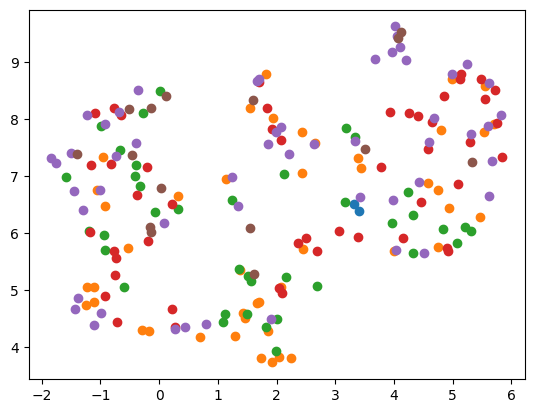

In [10]:
# Get transform and types
reducer = umap.UMAP(random_state=42)
transformed = reducer.fit_transform(states[-1, :, :env.dim])
types = env.dataloader.adatas[0].obs.loc[env.keys, 'layer'].to_numpy()

# Plot
fig, ax = plt.subplots()
for t in np.unique(types):
    ax.scatter(*transformed[types==t].T)
fig.show()
